In [1]:
import numpy as np

from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit_textbook.widgets import scalable_circuit # how circuit scales with the number of qubits
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy import pi

In [2]:
qc = QuantumCircuit(3)

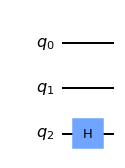

In [3]:
qc.h(2) # applying hadamard gate
qc.draw()

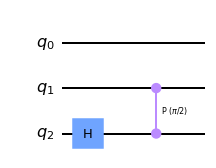

In [4]:
# if qubit in state |1> turn it an extra quarter

qc.cp(pi/2, 1, 2) # CROT from qubit1 to qubit2
qc.draw()

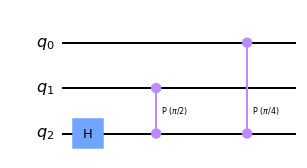

In [5]:
# another eigth turn if least significant qubit is |1>
qc.cp(pi/4, 0, 2)
qc.draw()

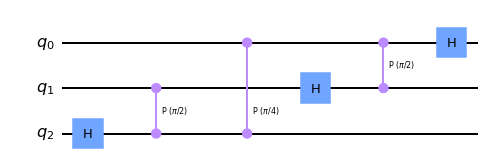

In [6]:
# repeat for qubits 0 and 1
qc.h(1)
qc.cp(pi/2, 0, 1) # CROT from qubit0 to qubit1
qc.h(0)
qc.draw()

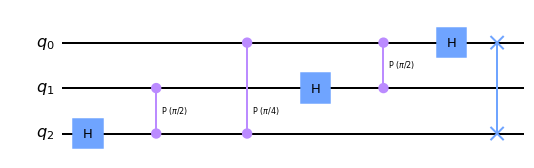

In [7]:
# swap qubit0 and qubit2

qc.swap(0,2)
qc.draw()

In [8]:
# create a circuit for QFT

def qft_rotations(circuit, n):
    if n==0:
        return circuit
    n-=1 # index starts from 0
    circuit.h(n) # hadamard gate on most significant bit
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n) # For each less significant qubit, smaller angle rotation

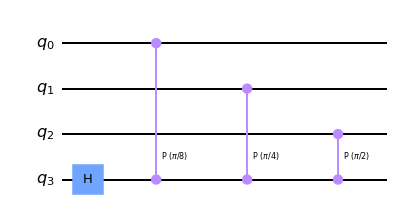

In [9]:
qc = QuantumCircuit(4)
qft_rotations(qc, 4)
qc.draw()

In [10]:
scalable_circuit(qft_rotations)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xfb\x00\x00\x01\x08\x08\x06\x00\x00\x00X\x8d]e\x…

In [11]:
def qft_rotations(circuit, n):
    #Performs qft on the first n qubits in circuit (without swaps)
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    
    qft_rotations(circuit, n) # call the same function again on the next qubits


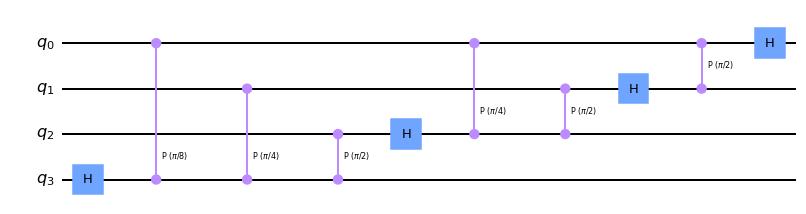

In [12]:
qc = QuantumCircuit(4)
qft_rotations(qc, 4)
qc.draw()

In [13]:
scalable_circuit(qft_rotations)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x19\x00\x00\x01\x08\x08\x06\x00\x00\x00\x1a\xcd,…

In [14]:
# Add swaps at the end of QFT

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit


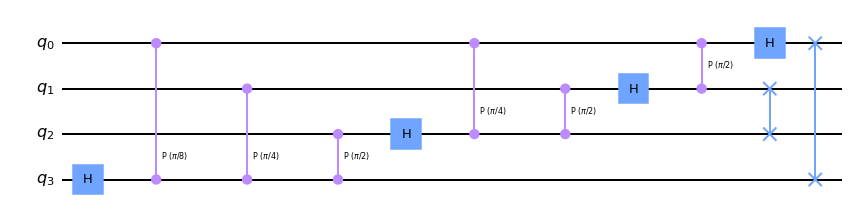

In [15]:
qc = QuantumCircuit(4)
qft(qc, 4)
qc.draw()

In [16]:
scalable_circuit(qft)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04U\x00\x00\x01\x08\x08\x06\x00\x00\x00\x9eK\xcbE\x…

In [17]:
# encoding a number in computational basis
num = int(input())
bin(num)

3


'0b11'

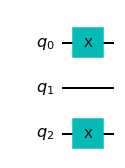

In [18]:
# encoding the number into qubits
qc = QuantumCircuit(3)

# Encode the state input
qc.x(0)
qc.x(2)
qc.draw()

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


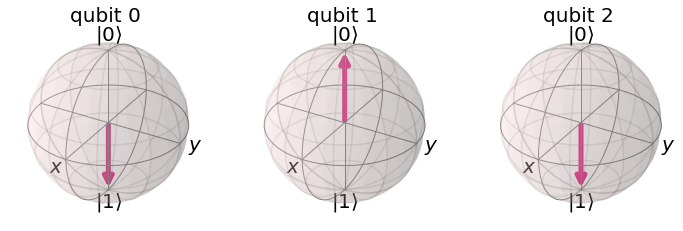

In [19]:
# checking the qubits states

sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

|0> compared to |+++> thus QFT function has worked properly

# Running QFT on a Quantum device

In [20]:
def inverse_qft(circuit, n):
    #Does the inverse QFT on the first n qubits in circuit

    qft_circ = qft(QuantumCircuit(n), n) # create a QFT circuit of the correct size
    invqft_circ = qft_circ.inverse() # Take inverse of this circuit
    circuit.append(invqft_circ, circuit.qubits[:n]) # Add to the first n qubits in our existing circuit
    
    return circuit.decompose() # .decompose() allows us to see the individual gates

In [21]:
nqubits = 3
qc = QuantumCircuit(nqubits)

for qubit in range(nqubits):
    qc.h(qubit)

qc.p(num*pi/4,0)
qc.p(num*pi/2,1)
qc.p(num*pi,2)

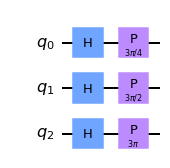

In [22]:
qc.draw()

results in Fourier state num

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


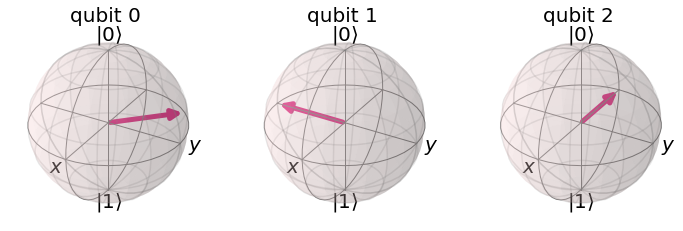

In [23]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

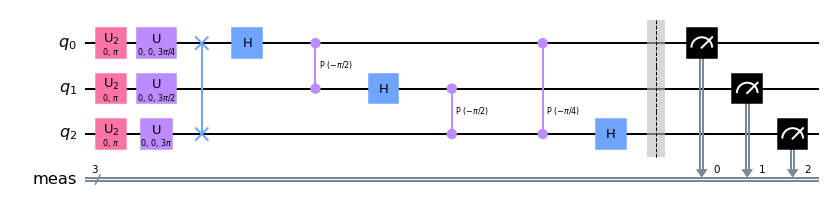

In [24]:
qc = inverse_qft(qc,nqubits)
qc.measure_all()
qc.draw()

In [25]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_quito


In [26]:
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(transpiled_qc, shots=shots)
job = backend.run(qobj)
job_monitor(job)

<ipython-input-26-c72f574f7484>:4: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Job Status: job has successfully run


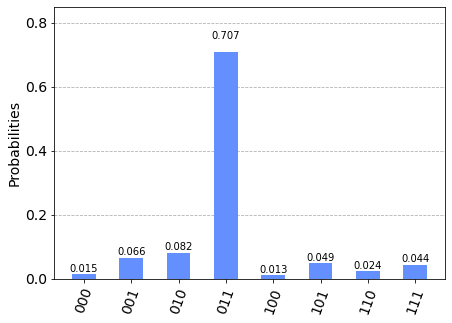

In [27]:
counts = job.result().get_counts()
plot_histogram(counts)

Highest probability outcome is the binary corresponding to num